# 0. Libraries

In [48]:
import scipy.io
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
import scienceplots

# 1. Extract

In [50]:
# Load the .mat file
mat_data = loadmat('NGA_W2_corr_meta_data.mat')

# 2. Transform

In [51]:
# Display the structure of the loaded data
variables_to_extract = ['Sa_RotD100', 'Sa_RotD50', 'closest_D', 'magnitude', 'soil_Vs30','lowest_usable_freq']
extracted_data = {}
Periods = mat_data['Periods']
Periods_orig = Periods.copy()

# Get index when Periods 10 s, where size (1,111)
idx_10s = np.where(Periods == 10)[1][0]
Periods = Periods[0][0:idx_10s+1] # Effective periods, size (1, 101)

# Loop through each variable and check if it exists in the .mat file
for var in variables_to_extract:
    if var in mat_data:
        extracted_data[var] = mat_data[var]
        print(f"{var}:", extracted_data[var])
    else:
        print(f"Variable '{var}' not found in the .mat file.")
        
# Create rsn variable that counts the number of rows in the extracted data
extracted_data_original = extracted_data.copy()
rsn= extracted_data['Sa_RotD100'].shape[0]
rsn_list = np.arange(1, rsn + 1)

# Check extracted data and delete rows with NaN and -999 values except, have to do this at the same time for all variables
# For each variable, accumulate the rows with NaN and -999 values and then create a unique list of rows to delete
unique_rows_to_delete = []
for var in extracted_data:
    rows_to_delete = []
    for i in range(rsn):
        if np.any(np.isnan(extracted_data[var][i])) or np.any(extracted_data[var][i] == -999) or np.any(extracted_data[var][i] == 0):
            rows_to_delete.append(i)
    unique_rows_to_delete = np.unique(np.concatenate((unique_rows_to_delete, rows_to_delete)))
    print(f"Rows to delete for {var}:", rows_to_delete)

unique_rows_to_delete = unique_rows_to_delete.astype(int)

# Delete the rows with NaN and -999 values for all variables
for var in extracted_data:
    extracted_data[var] = np.delete(extracted_data[var], unique_rows_to_delete, axis=0)
    print(f"Shape of {var}:", extracted_data[var].shape)
rsn_list = np.delete(rsn_list, unique_rows_to_delete, axis=0)

# Compute ratio of Sa_RotD100/Sa_RotD50 for each rsn (row) and column
Sa_RotD100 = extracted_data['Sa_RotD100']
Sa_RotD50 = extracted_data['Sa_RotD50']
ratio_rotd = np.zeros((rsn_list.shape[0], Sa_RotD100.shape[1]))
for i in range(rsn_list.shape[0]):
    for j in range(Sa_RotD100.shape[1]):
        ratio_rotd[i,j] = Sa_RotD100[i, j] / Sa_RotD50[i, j]
        
# Identify those rows with ratio of Sa_RotD100/Sa_RotD50 > 1.415 = sqrt(2) and Sa_RotD100/Sa_RotD50 < 1, give them in rsn values - by definition
rsn_out_threshold = []
i_delete = []
for i in range(ratio_rotd.shape[0]):
    if np.any(ratio_rotd[i, :] > 1.415) or np.any(ratio_rotd[i, :] < 1):
        rsn_out_threshold.append(rsn_list[i])
        i_delete.append(i)

for var in extracted_data:
    extracted_data[var] = np.delete(extracted_data[var], i_delete, axis=0)
    print(f"Shape of {var}:", extracted_data[var].shape)
rsn_list = np.delete(rsn_list, i_delete, axis=0)

# Identify those rows with closest_D > 200 km and delete them
rsn_out_distance = []
i_delete = []
for i in range(extracted_data['closest_D'].shape[0]):
    if extracted_data['closest_D'][i] > 200:
        rsn_out_distance.append(rsn_list[i])
        i_delete.append(i)

for var in extracted_data:
    extracted_data[var] = np.delete(extracted_data[var], i_delete, axis=0)
rsn_list = np.delete(rsn_list, i_delete, axis=0)

# Reduce the number of columns to 101 period, from 0 to 10 s
for var in extracted_data:
    extracted_data[var] = extracted_data[var][:, 0:idx_10s+1]
    print(f"Shape of {var}:", extracted_data[var].shape)


Sa_RotD100: [[1.762011e-01 1.784339e-01 1.807870e-01 ... 8.313637e-04 7.273380e-04
  4.146704e-04]
 [5.381928e-02 5.627734e-02 5.606911e-02 ... 1.051040e-05 9.119646e-06
  5.067681e-06]
 [4.558242e-02 4.590505e-02 4.599739e-02 ... 1.050110e-04 9.222933e-05
  5.536199e-05]
 ...
 [6.769351e-04 6.661694e-04 6.705823e-04 ... 2.434844e-07 2.130040e-07
  1.174579e-07]
 [3.705074e-03 3.750760e-03 3.771360e-03 ... 6.467141e-07 5.651588e-07
  3.095832e-07]
 [2.131170e-03 2.097414e-03 2.103398e-03 ... 5.493273e-07 4.860101e-07
  2.845914e-07]]
Sa_RotD50: [[1.619342e-01 1.639006e-01 1.651172e-01 ... 5.907200e-04 5.168520e-04
  2.947800e-04]
 [4.751961e-02 4.916894e-02 4.914828e-02 ... 7.514000e-06 6.519800e-06
  3.622870e-06]
 [4.099701e-02 4.118426e-02 4.123356e-02 ... 8.767750e-05 7.710520e-05
  4.424700e-05]
 ...
 [5.054930e-04 4.995341e-04 5.003494e-04 ... 2.108207e-07 1.832552e-07
  1.013207e-07]
 [3.058198e-03 3.058668e-03 3.073464e-03 ... 5.369460e-07 4.686200e-07
  2.628650e-07]
 [1.61950

In [52]:
# Identify those rows with lowest_usable_freq > 0.1 Hz and fill their columns with NaN for periods > 1/lowest_usable_freq
rsn_out_freq = []
i_delete = []
for i in range(extracted_data['lowest_usable_freq'].shape[0]):
    if extracted_data['lowest_usable_freq'][i] > 0.1:
        period_luf = 1 / extracted_data['lowest_usable_freq'][i]
        # Find period index near lower to 1/lowest_usable_freq
        lower_values = Periods[Periods < period_luf]
        if lower_values.size > 0:
            closest_period = lower_values[np.argmax(lower_values)]
            idx_closest_period = np.where(Periods == closest_period)[0][0]
            extracted_data['Sa_RotD100'][i, idx_closest_period+1:] = np.nan
            extracted_data['Sa_RotD50'][i, idx_closest_period+1:] = np.nan
        else:
            print(f"Periods less than {period_luf} not found.")

"""
rsn_out_freq = []
i_delete = []
for i in range(extracted_data['lowest_usable_freq'].shape[0]):
    if extracted_data['lowest_usable_freq'][i] > 0.1:
        rsn_out_freq.append(rsn_list[i])
        i_delete.append(i)
        
for var in extracted_data:
    extracted_data[var] = np.delete(extracted_data[var], i_delete, axis=0)
rsn_list = np.delete(rsn_list, i_delete, axis=0)
"""


"\nrsn_out_freq = []\ni_delete = []\nfor i in range(extracted_data['lowest_usable_freq'].shape[0]):\n    if extracted_data['lowest_usable_freq'][i] > 0.1:\n        rsn_out_freq.append(rsn_list[i])\n        i_delete.append(i)\n        \nfor var in extracted_data:\n    extracted_data[var] = np.delete(extracted_data[var], i_delete, axis=0)\nrsn_list = np.delete(rsn_list, i_delete, axis=0)\n"

In [53]:
# Compute ratio of Sa_RotD100/Sa_RotD50 for each rsn (row) and only for columns with no NaN values
Sa_RotD100 = extracted_data['Sa_RotD100']
Sa_RotD50 = extracted_data['Sa_RotD50']
ratio_rotd = np.zeros((rsn_list.shape[0], Sa_RotD100.shape[1]))
for i in range(rsn_list.shape[0]):
    for j in range(Sa_RotD100.shape[1]):
        if not np.isnan(Sa_RotD100[i, j]) and not np.isnan(Sa_RotD50[i, j]):
            ratio_rotd[i,j] = Sa_RotD100[i, j] / Sa_RotD50[i, j]
        else:
            ratio_rotd[i,j] = np.nan

In [54]:
Periods.shape

(105,)

In [55]:
# Analyze rsn_list
rsn_list.shape

(17716,)

In [56]:
rsn_list

array([    1,     2,     3, ..., 21537, 21538, 21539])

In [57]:
# Analyze extracted_data
extracted_data

{'Sa_RotD100': array([[0.1762011 , 0.1784339 , 0.180787  , ...,        nan,        nan,
                nan],
        [0.05381928, 0.05627734, 0.05606911, ...,        nan,        nan,
                nan],
        [0.04558242, 0.04590505, 0.04599739, ...,        nan,        nan,
                nan],
        ...,
        [0.00067694, 0.00066617, 0.00067058, ...,        nan,        nan,
                nan],
        [0.00370507, 0.00375076, 0.00377136, ...,        nan,        nan,
                nan],
        [0.00213117, 0.00209741, 0.0021034 , ...,        nan,        nan,
                nan]]),
 'Sa_RotD50': array([[0.1619342 , 0.1639006 , 0.1651172 , ...,        nan,        nan,
                nan],
        [0.04751961, 0.04916894, 0.04914828, ...,        nan,        nan,
                nan],
        [0.04099701, 0.04118426, 0.04123356, ...,        nan,        nan,
                nan],
        ...,
        [0.00050549, 0.00049953, 0.00050035, ...,        nan,        nan,
       

In [58]:
# analyze Sa_RotD100
extracted_data["Sa_RotD100"].shape

(17716, 105)

In [59]:
# analyze Sa_RotD50
extracted_data["Sa_RotD50"].shape

(17716, 105)

In [60]:
# analyze magnitude
extracted_data["magnitude"].shape

(17716, 1)

In [61]:
# Initialize a new dictionary for expanded data
expanded_data = {}

# Iterate through the original dictionary
for key, value in extracted_data.items():
    # Check if the value is a 2D array
    if len(value.shape) > 1:
        # Create new keys for each column
        for i in range(value.shape[1]):  # Loop through columns
            if key != "closest_D" and key != "magnitude" and key != "soil_Vs30":
                expanded_data[f"{key}_T{i+1}"] = value[:, i]
            else:
                expanded_data[f"{key}"] = value[:, i]

    else:
        # If it's a 1D array, just assign it directly
        expanded_data[key] = value

# Create a DataFrame from the expanded data
df_expanded_data = pd.DataFrame(expanded_data)

df_expanded_data

,Sa_RotD100_T1,Sa_RotD100_T2,Sa_RotD100_T3,Sa_RotD100_T4,Sa_RotD100_T5,Sa_RotD100_T6,Sa_RotD100_T7,Sa_RotD100_T8,Sa_RotD100_T9,Sa_RotD100_T10,...,Sa_RotD50_T100,Sa_RotD50_T101,Sa_RotD50_T102,Sa_RotD50_T103,Sa_RotD50_T104,Sa_RotD50_T105,closest_D,magnitude,soil_Vs30,lowest_usable_freq_T1
0,0.176201,0.178434,0.180787,0.183714,0.190016,0.193431,0.202666,0.222450,0.228174,0.247553,...,NaN,NaN,NaN,NaN,NaN,NaN,2.86,6.0,593.35,0.162500
1,0.053819,0.056277,0.056069,0.057316,0.064570,0.065244,0.069159,0.070873,0.071708,0.080807,...,NaN,NaN,NaN,NaN,NaN,NaN,2.92,6.0,551.82,0.500000
2,0.045582,0.045905,0.045997,0.046184,0.046646,0.046720,0.046911,0.046695,0.046636,0.046241,...,NaN,NaN,NaN,NaN,NaN,NaN,71.57,5.8,219.31,0.375000
3,0.021930,0.022245,0.022351,0.022733,0.023042,0.023228,0.023367,0.023635,0.023407,0.025159,...,NaN,NaN,NaN,NaN,NaN,NaN,34.98,5.0,213.44,0.875000
4,0.165307,0.167300,0.168709,0.169770,0.169003,0.170108,0.172069,0.174661,0.176181,0.181674,...,NaN,NaN,NaN,NaN,NaN,NaN,53.58,5.5,219.31,0.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17711,0.000492,0.000502,0.000506,0.000506,0.000512,0.000513,0.000506,0.000504,0.000515,0.000542,...,NaN,NaN,NaN,NaN,NaN,NaN,51.11,3.6,391.55,0.318710
17712,0.007184,0.007202,0.007230,0.007283,0.007289,0.007351,0.007494,0.007565,0.007587,0.007591,...,NaN,NaN,NaN,NaN,NaN,NaN,35.63,3.6,723.35,0.902378
17713,0.000677,0.000666,0.000671,0.000681,0.000679,0.000681,0.000678,0.000669,0.000673,0.000711,...,NaN,NaN,NaN,NaN,NaN,NaN,51.36,3.6,432.00,0.644350
17714,0.003705,0.003751,0.003771,0.003783,0.003877,0.003892,0.004106,0.004566,0.004658,0.004936,...,NaN,NaN,NaN,NaN,NaN,NaN,39.13,3.6,535.12,0.627871


In [62]:
# Compute the geometric mean (median) of Sa_RotD100 and Sa_RotD50 for each column with no NaN values
Sa_RotD100_median = np.exp(np.nanmean(np.log(Sa_RotD100), axis=0)) # Only for columns with no NaN values
Sa_RotD50_median = np.exp(np.nanmean(np.log(Sa_RotD50), axis=0))

# Compute the log variance of Sa_RotD100 and Sa_RotD50 for each column with no NaN values
Sa_RotD100_var = np.nanvar(np.log(Sa_RotD100), axis=0, ddof=1)
Sa_RotD50_var = np.nanvar(np.log(Sa_RotD50), axis=0, ddof=1)

# Compute the geometric mean (median) of of the ratio subset per period for each column with no NaN values
ratio_rotd_median= np.exp(np.nanmean(np.log(ratio_rotd), axis=0))
ratio_rotd_var = np.nanvar(np.log(ratio_rotd), axis=0, ddof=1)

Sa_RotD50_median

array([0.00369682, 0.00372982, 0.00375855, 0.00382329, 0.00391773,
       0.00394405, 0.00400429, 0.00410319, 0.00413711, 0.00428351,
       0.00436373, 0.00444864, 0.00449303, 0.00453835, 0.0046327 ,
       0.00471893, 0.00497476, 0.00524908, 0.00552479, 0.00563558,
       0.00580122, 0.00607512, 0.00633123, 0.00656297, 0.0067781 ,
       0.00698915, 0.00715473, 0.00748109, 0.0077669 , 0.00797832,
       0.00802805, 0.00812984, 0.0082145 , 0.00823422, 0.00821849,
       0.0081692 , 0.00810159, 0.00801677, 0.0077628 , 0.00745472,
       0.00729331, 0.00713139, 0.00680806, 0.00664579, 0.00648415,
       0.00616056, 0.00584383, 0.00568447, 0.00553033, 0.0052373 ,
       0.00496375, 0.00470444, 0.00446723, 0.00435631, 0.00424197,
       0.00403109, 0.00383588, 0.00338715, 0.00301413, 0.00270325,
       0.00261678, 0.00243796, 0.00221274, 0.00200196, 0.00182846,
       0.00168576, 0.0015586 , 0.00144761, 0.00126393, 0.00112005,
       0.00100989, 0.00091508, 0.00085414, 0.00080757, 0.00075

In [63]:
Periods.flatten()

array([ 0.01 ,  0.02 ,  0.022,  0.025,  0.029,  0.03 ,  0.032,  0.035,
        0.036,  0.04 ,  0.042,  0.044,  0.045,  0.046,  0.048,  0.05 ,
        0.055,  0.06 ,  0.065,  0.067,  0.07 ,  0.075,  0.08 ,  0.085,
        0.09 ,  0.095,  0.1  ,  0.11 ,  0.12 ,  0.13 ,  0.133,  0.14 ,
        0.15 ,  0.16 ,  0.17 ,  0.18 ,  0.19 ,  0.2  ,  0.22 ,  0.24 ,
        0.25 ,  0.26 ,  0.28 ,  0.29 ,  0.3  ,  0.32 ,  0.34 ,  0.35 ,
        0.36 ,  0.38 ,  0.4  ,  0.42 ,  0.44 ,  0.45 ,  0.46 ,  0.48 ,
        0.5  ,  0.55 ,  0.6  ,  0.65 ,  0.667,  0.7  ,  0.75 ,  0.8  ,
        0.85 ,  0.9  ,  0.95 ,  1.   ,  1.1  ,  1.2  ,  1.3  ,  1.4  ,
        1.5  ,  1.6  ,  1.7  ,  1.8  ,  1.9  ,  2.   ,  2.2  ,  2.4  ,
        2.5  ,  2.6  ,  2.8  ,  3.   ,  3.2  ,  3.4  ,  3.5  ,  3.6  ,
        3.8  ,  4.   ,  4.2  ,  4.4  ,  4.6  ,  4.8  ,  5.   ,  5.5  ,
        6.   ,  6.5  ,  7.   ,  7.5  ,  8.   ,  8.5  ,  9.   ,  9.5  ,
       10.   ])

In [64]:
# create Log_periods column
Log_period = np.log10(Periods.flatten())
Log_period

array([-2.        , -1.69897   , -1.65757732, -1.60205999, -1.537602  ,
       -1.52287875, -1.49485002, -1.45593196, -1.4436975 , -1.39794001,
       -1.37675071, -1.35654732, -1.34678749, -1.33724217, -1.31875876,
       -1.30103   , -1.25963731, -1.22184875, -1.18708664, -1.1739252 ,
       -1.15490196, -1.12493874, -1.09691001, -1.07058107, -1.04575749,
       -1.02227639, -1.        , -0.95860731, -0.92081875, -0.88605665,
       -0.87614836, -0.85387196, -0.82390874, -0.79588002, -0.76955108,
       -0.74472749, -0.7212464 , -0.69897   , -0.65757732, -0.61978876,
       -0.60205999, -0.58502665, -0.55284197, -0.537602  , -0.52287875,
       -0.49485002, -0.46852108, -0.45593196, -0.4436975 , -0.4202164 ,
       -0.39794001, -0.37675071, -0.35654732, -0.34678749, -0.33724217,
       -0.31875876, -0.30103   , -0.25963731, -0.22184875, -0.18708664,
       -0.17587417, -0.15490196, -0.12493874, -0.09691001, -0.07058107,
       -0.04575749, -0.02227639,  0.        ,  0.04139269,  0.07

## 2.1 Create working dataset

In [65]:
# Creating the dataframe
working_dic = {
    'Periods': Periods.flatten(),
    'Log_periods':Log_period,
    'Sa_RotD100_var': Sa_RotD100_var,
    'Sa_RotD50_var': Sa_RotD50_var,
    'Ratio_median': ratio_rotd_median,
    'Ratio_var': ratio_rotd_var
}

working_df = pd.DataFrame(working_dic)

working_df

,Periods,Log_periods,Sa_RotD100_var,Sa_RotD50_var,Ratio_median,Ratio_var
0,0.010,-2.000000,5.940487,5.913302,1.200727,0.007216
1,0.020,-1.698970,5.969157,5.942358,1.199830,0.007161
2,0.022,-1.657577,5.969779,5.942977,1.199338,0.007126
3,0.025,-1.602060,5.960107,5.934452,1.198367,0.007053
4,0.029,-1.537602,5.956376,5.930309,1.197620,0.006993
...,...,...,...,...,...,...
100,8.000,0.903090,10.583575,10.465022,1.266621,0.007087
101,8.500,0.929419,10.674717,10.557460,1.269646,0.007057
102,9.000,0.954243,10.408240,10.288896,1.271049,0.007052
103,9.500,0.977724,10.412511,10.291872,1.271696,0.007054


## 2.2 Plot Sa_RotD100_var

In [66]:
ratio_real_var = np.nanvar(ratio_rotd, axis=0, ddof=1)

# square root of the variance
ratio_rotd_var_sqrt = np.sqrt(ratio_real_var) # Standard deviation
#Top bound 1 std above the median
ratio_rotd_median_plus = ratio_rotd_median + ratio_rotd_var_sqrt
#Bottom bound 1 std below the median
ratio_rotd_median_minus = ratio_rotd_median - ratio_rotd_var_sqrt



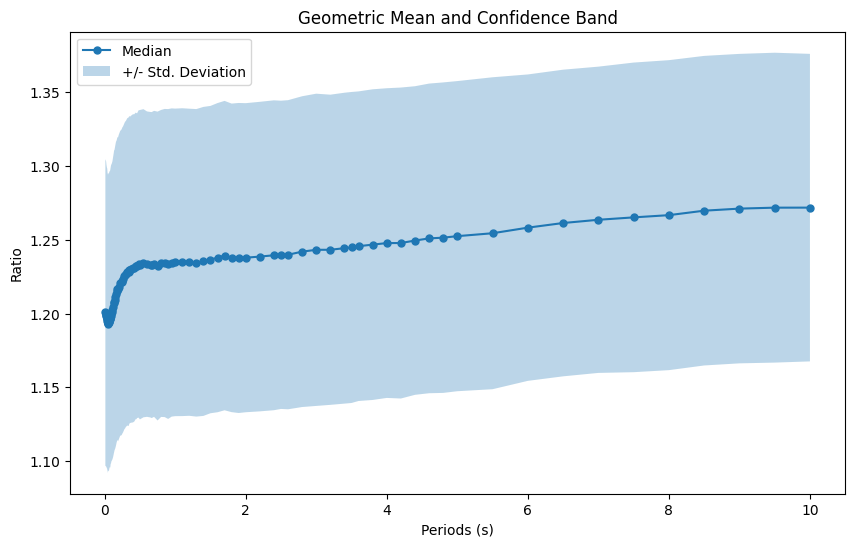

In [67]:
plt.figure(figsize=(10, 6))

# Plot the geometric mean
plt.plot(Periods, ratio_rotd_median, marker='o', markersize=5, label="Median")

# Plot the confidence band using fill_between
plt.fill_between(
    Periods,
    ratio_rotd_median_minus,
    ratio_rotd_median_plus,

    alpha=0.3,
    label="+/- Std. Deviation"
)

# Customize the plot
plt.xlabel('Periods (s)')
plt.ylabel('Ratio')
plt.title('Geometric Mean and Confidence Band')
plt.legend()

# Show the plot
plt.show()

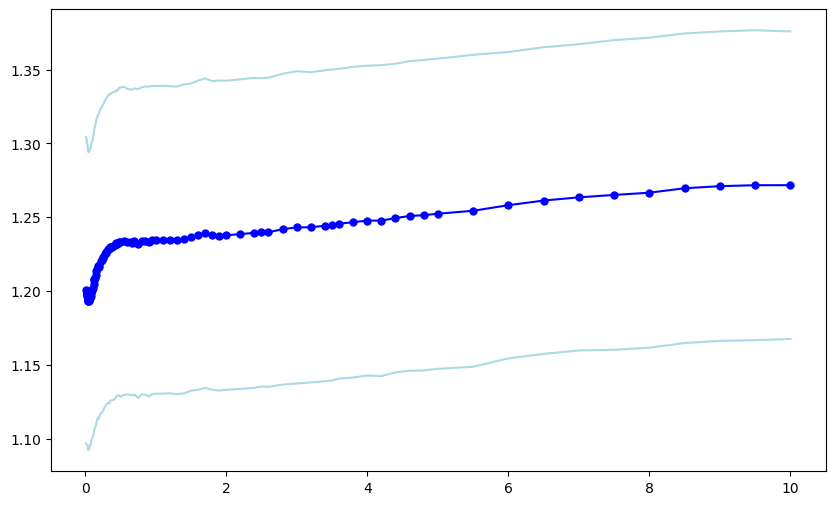

In [68]:
plt.figure(figsize=(10, 6))
# Plot the geometric mean
plt.plot(Periods, ratio_rotd_median, color='blue', marker='o', markersize=5, label="Median")

# Plot +/- 1 standard deviation
plt.plot(Periods, ratio_rotd_median_plus, color='lightblue', linestyle='-', label="+/- Std. Deviation")
plt.plot(Periods, ratio_rotd_median_minus, color='lightblue', linestyle='-')

# Show the plot
plt.show()


NameError: name 'save_path' is not defined

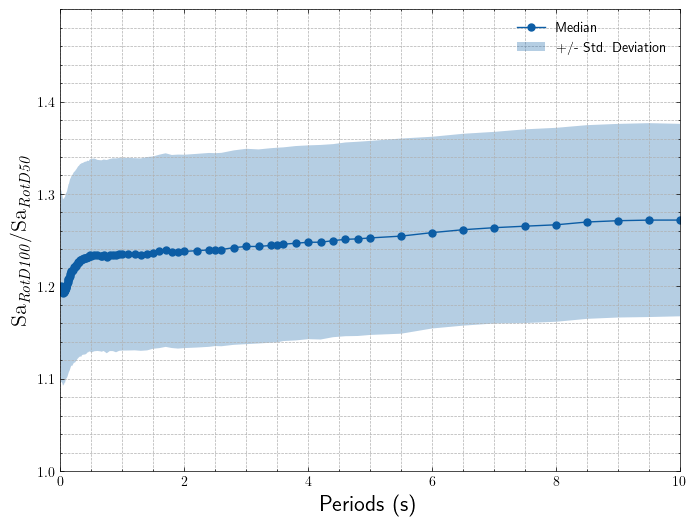

In [69]:
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the geometric mean (median)
    ax.plot(
        Periods, ratio_rotd_median, marker='o', markersize=5, label="Median"
    )

    # Plot the confidence band using fill_between
    ax.fill_between(
        Periods,
        ratio_rotd_median_minus,
        ratio_rotd_median_plus,
        alpha=0.3,
        label="+/- Std. Deviation"
    )

    # Customize the plot
    ax.set_xlabel("Periods (s)", fontsize=16)
    ax.set_ylabel(r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$", fontsize=16)
    ax.set_xlim(0, 10)
    ax.set_ylim(1, 1.5)
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_yticks(np.arange(1, 1.5, 0.1))
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Add legend
    ax.legend(loc="best")
    if save_path:
    # Ensure the save path ends with a slash and construct the file name
        save_path = save_path.rstrip("/") + "/"
        full_file_path = f"{save_path}{file_name}.png"
        fig.savefig(full_file_path, format="png", dpi=600)  # Set DPI to 600 for high quality
        print(f"Plot saved as PNG at {full_file_path}")

    # Show the plot
    plt.show()

In [70]:
save_path = "figures_report/"
file_name = "scatter_plot_median_std_deviation"

Plot saved as PNG at figures_report/scatter_plot_median_std_deviation.png


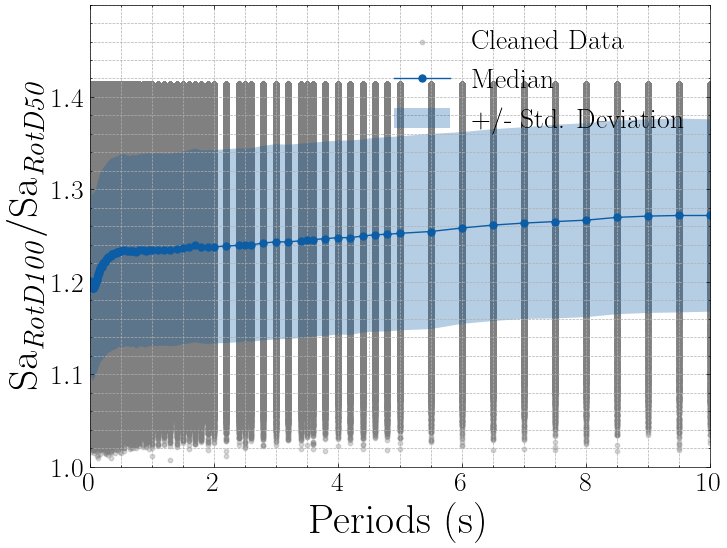

In [73]:
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plot for the raw data
    for i in range(ratio_rotd.shape[0]):
        valid_indices = ~np.isnan(ratio_rotd[i, :])
        valid_periods = Periods[valid_indices]
        valid_ratios = ratio_rotd[i, valid_indices]
        ax.scatter(
            valid_periods, valid_ratios, s=10, color='gray', alpha=0.3, 
            label="Cleaned Data" if i == 0 else ""
        )

    # Plot the geometric mean (median)
    ax.plot(
        Periods, ratio_rotd_median, marker='o', markersize=5, label="Median"
    )

    # Plot the confidence band using fill_between
    ax.fill_between(
        Periods,
        ratio_rotd_median_minus,
        ratio_rotd_median_plus,
        alpha=0.3,
        label="+/- Std. Deviation"
    )

    # Customize the plot
    ax.set_xlabel("Periods (s)", fontsize=30)
    ax.set_ylabel(r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$", fontsize=30)
    ax.set_xlim(0, 10)
    ax.set_ylim(1, 1.5)
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_yticks(np.arange(1, 1.5, 0.1))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Add legend
    ax.legend(loc="upper right", fontsize=20)
    if save_path:
    # Ensure the save path ends with a slash and construct the file name
        save_path = save_path.rstrip("/") + "/"
        full_file_path = f"{save_path}{file_name}.png"
        fig.savefig(full_file_path, format="png", dpi=600)  # Set DPI to 600 for high quality
        print(f"Plot saved as PNG at {full_file_path}")

    # Show the plot
    plt.show()

In [ ]:
def plot_scatter_with_save(x, y, ylabel, save_path, file_name):
    """
    Plots a scatter plot with customized axes and labels, and saves the plot as a high-quality PNG.

    Parameters:
    - x: Array-like, data for the x-axis.
    - y: Array-like, data for the y-axis.
    - ylabel: Label for the y-axis (str), typically a LaTeX-formatted string.
    - save_path: Optional (str). Directory path to save the plot. If None, the plot is not saved.
    - file_name: Optional (str). Name of the file to be saved (without extension). Default is "scatter_plot".
    
    Example Usage:
    plot_scatter_with_save(
        x=Periods,
        y=ratios,
        ylabel=r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$",
        save_path="figures_report",
        file_name="scatter_plot"
    )
    """
    with plt.style.context(['science']):
        fig, ax = plt.subplots(figsize=(8, 6))

        # Scatter plot
        ax.scatter(x, y, s=20)

        # Customize the plot
        ax.set_xlabel("Periods (s)", fontsize=19)
        ax.set_ylabel(ylabel, fontsize=19)
        ax.set_xscale("log")  # Set the x-axis to logarithmic scale
        ax.set_xlim(0, 10)

        # Save the plot if save_path is provided
        if save_path:
            # Ensure the save path ends with a slash and construct the file name
            save_path = save_path.rstrip("/") + "/"
            full_file_path = f"{save_path}{file_name}.png"
            fig.savefig(full_file_path, format="png", dpi=600)  # High-quality PNG
            print(f"Plot saved as PNG at {full_file_path}")

        # Show the plot
        plt.show()


In [ ]:
# No logaritmic
plt.figure()
plt.plot(working_df['Periods'].iloc[:], working_df['Sa_RotD100_var'].iloc[:], 'o')
plt.xlabel('Periods')
plt.ylabel('Sa_RotD100_var')
plt.title('Sa_RotD100_var vs Periods')
plt.show()

In [ ]:
file_name = "var_rotd100"
ylabel = r"$\sigma_{\ln \mathrm{Sa}_{\mathit{RotD100}}}^2$"

In [ ]:
plot_scatter_with_save(
    x=working_df['Periods'].iloc[:],
    y=working_df['Sa_RotD100_var'].iloc[:],
    ylabel=ylabel,
    save_path=save_path,
    file_name=file_name
)

In [ ]:
# Logaritmic
plt.figure()
plt.plot(working_df['Log_periods'].iloc[:], working_df['Sa_RotD100_var'].iloc[:], 'o')
plt.xlabel('Log_periods')
plt.ylabel('Sa_RotD100_var')
plt.title('Sa_RotD100_var vs Log_periods')
plt.show()

## 2.3 Plot Sa_RotD50_var

In [ ]:
# No logaritmic
plt.figure()
plt.plot(working_df['Periods'].iloc[:], working_df['Sa_RotD50_var'].iloc[:], 'o')
plt.xlabel('Periods')
plt.ylabel('Sa_RotD50_var')
plt.title('Sa_RotD50_var vs Periods')
plt.show()

In [ ]:
file_name = "var_rotd50"
ylabel = r"$\sigma_{\ln \mathrm{Sa}_{\mathit{RotD50}}}^2$"

In [ ]:
plot_scatter_with_save(
    x=working_df['Periods'].iloc[:],
    y=working_df['Sa_RotD50_var'].iloc[:],
    ylabel=ylabel,
    save_path=save_path,
    file_name=file_name
)

In [ ]:
# Logaritmic
plt.figure()
plt.plot(working_df['Log_periods'].iloc[:], working_df['Sa_RotD50_var'].iloc[:], 'o')
plt.xlabel('Log_periods')
plt.ylabel('Sa_RotD50_var')
plt.title('Sa_RotD50_var vs Log_periods')
plt.show()

## 2.4 Plot Ratio_median

In [ ]:
# No logaritmic
plt.figure()
plt.plot(working_df['Periods'].iloc[:], working_df['Ratio_median'].iloc[:], 'o')
plt.xlabel('Periods')
plt.ylabel('Ratio_median')
plt.title('Ratio_median vs Periods')
plt.show()

In [ ]:
file_name = "ratio_med"
ylabel = r"$\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}$"

In [ ]:
plot_scatter_with_save(
    x=working_df['Periods'].iloc[:],
    y=working_df['Ratio_median'].iloc[:],
    ylabel=ylabel,
    save_path=save_path,
    file_name=file_name
)

In [ ]:
# Logaritmic
plt.figure()
plt.plot(working_df['Log_periods'].iloc[:], working_df['Ratio_median'].iloc[:], 'o')
plt.xlabel('Log_periods')
plt.ylabel('Ratio_median')
plt.title('Ratio_median vs Log_periods')
plt.show()

## 2.5 Plot Ratio_var

In [ ]:
# No logaritmic
plt.figure()
plt.plot(working_df['Periods'].iloc[:], working_df['Ratio_var'].iloc[:], 'o')
plt.xlabel('Periods')
plt.ylabel('Ratio_var')
plt.title('Ratio_var vs Periods')
plt.show()

In [ ]:
file_name = "var_ratio_med"
ylabel = r"$\sigma_{\ln \left(\mathrm{Sa}_{\mathit{RotD100}} / \mathrm{Sa}_{\mathit{RotD50}}\right)}^2$"

In [ ]:
plot_scatter_with_save(
    x=working_df['Periods'].iloc[:],
    y=working_df['Ratio_var'].iloc[:],
    ylabel=ylabel,
    save_path=save_path,
    file_name=file_name
)

In [ ]:
# Logaritmic
plt.figure()
plt.plot(working_df['Log_periods'].iloc[:], working_df['Ratio_var'].iloc[:], 'o')
plt.xlabel('Log_periods')
plt.ylabel('Ratio_var')
plt.title('Ratio_var vs Log_periods')
plt.show()

# 3. Save Data

In [ ]:
# Save predict_var to a pickle file in the datasets folder
working_df.to_pickle('datasets/working_df.pkl')


# 4. Plots

In [ ]:
# Plot the ratio of Sa_RotD100/Sa_RotD50 for each period
plt.figure(figsize=(7, 7))  # Set figure size for journal standards
plt.semilogx(working_df['Periods'].iloc[:], working_df['Ratio_median'].iloc[:], 'o-', markersize=4, linewidth=1.5, color='blue', label=r'$\mathrm{Median\ Ratio}$')
plt.xlabel(r'$\mathrm{Period\ (s)}$', fontsize=12, labelpad=10)
plt.ylabel(r'$\mathrm{Sa_{RotD100}/Sa_{RotD50}}$', fontsize=12, labelpad=10)
plt.title(r'$\mathrm{Ratio\ of\ Sa_{RotD100}/Sa_{RotD50}\ vs.\ Periods}$', fontsize=14, pad=15)
xticks = [0.01, 0.1, 1, 10]  # Logarithmic positions for ticks
xtick_labels = [r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$']  # Labels for ticks
plt.xticks(xticks, labels=xtick_labels, fontsize=10)
yticks = np.arange(1.15, 1.33, 0.03)  # Generate ticks for y-axis
plt.yticks(yticks, fontsize=10)  # Apply the ticks with specific font size
plt.minorticks_on()  # Enable minor ticks
plt.tick_params(axis='x', direction='in', length=10, width=1, which='major')  # Major ticks
plt.tick_params(axis='y', direction='in', length=5, width=0.05, which='minor')  # Minor ticks
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7, which='major')  # Add grid
plt.xlim([0.01, 10])  # Set x-axis limits
plt.ylim([1.15, 1.3])  # Set y-axis limits
plt.legend(fontsize=10, loc='upper right', frameon=False)  # Add legend

plt.tight_layout()  # Adjust layout
plt.savefig('Sa_Ratio_vs_Periods.pdf', dpi=300, bbox_inches='tight')  # Save as PDF
plt.savefig('Sa_Ratio_vs_Periods.png', dpi=300, bbox_inches='tight')  # Save as PNG

plt.show()  # Display the plot